<a href="https://colab.research.google.com/github/bhavinikasana12/bert-toxicity-detector/blob/main/bert_toxicity_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aif360 transformers shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.0 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("julian3833/jigsaw-unintended-bias-in-toxicity-classification")

print("Path to dataset files:", path)


100%|██████████| 723M/723M [00:05<00:00, 148MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/julian3833/jigsaw-unintended-bias-in-toxicity-classification/versions/1


In [3]:
import pandas as pd

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/julian3833/jigsaw-unintended-bias-in-toxicity-classification/versions/1/train.csv"

# Load into pandas
df = pd.read_csv(dataset_path)

# Display first few rows
df.head()
print(f"Dataset shape: {df.shape}")


Dataset shape: (1804874, 45)


In [4]:
# Drop irrelevant columns (modify based on analysis)
df = df.drop(columns=["id"])  # 'id' is not needed for training

# Drop rows with missing values
df = df.dropna()

# Check if data is clean
print(f"After cleaning, dataset shape: {df.shape}")


After cleaning, dataset shape: (235085, 44)


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already available
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')
# Define stopwords
stop_words = set(stopwords.words("english"))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = re.sub(r"\d+", "", text)  # Remove numbers
    words = word_tokenize(text)  # Tokenize words
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Apply cleaning function to all comments
df["clean_text"] = df["comment_text"].apply(clean_text)

# Show cleaned text
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,clean_text
11,0.4400,This is a great story. Man. I wonder if the pe...,0.00,0.293333,0.0000,0.3200,0.0000,0.0,0.0,0.0,...,approved,0,0,0,1,0,0.04,10,75,great story man wonder person yelled shut fuck...
31,0.9125,Yet call out all Muslims for the acts of a few...,0.05,0.237500,0.6125,0.8875,0.1125,0.0,0.0,0.0,...,approved,0,0,0,1,0,0.00,4,80,yet call muslims acts get pilloried okay smear...
51,0.0000,Because the people who drive cars more are the...,0.00,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,...,approved,0,0,0,0,0,0.00,4,4,people drive cars ones cause wear tear roads p...
58,0.3000,Mormons have had a complicated relationship wi...,0.00,0.000000,0.3000,0.0000,0.0000,0.0,0.0,0.0,...,approved,0,0,0,2,0,0.00,10,10,mormons complicated relationship federal law
111,0.0000,I'm doing the same thing! :),0.00,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,...,approved,0,0,0,1,0,0.00,4,4,im thing


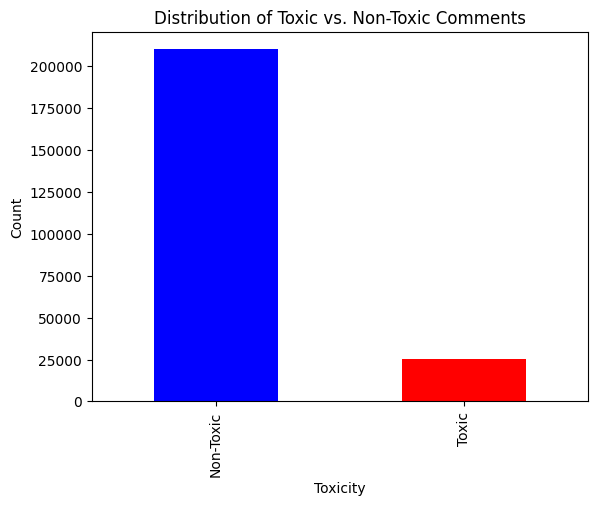

In [6]:
import matplotlib.pyplot as plt

# Convert toxicity scores to binary labels (Assuming 0.5 is the threshold)
df["toxic_label"] = df["target"].apply(lambda x: 1 if x >= 0.5 else 0)

# Count and plot
df["toxic_label"].value_counts().plot(kind="bar", color=["blue", "red"])
plt.xlabel("Toxicity")
plt.ylabel("Count")
plt.title("Distribution of Toxic vs. Non-Toxic Comments")
plt.xticks(ticks=[0, 1], labels=["Non-Toxic", "Toxic"])  # Fix x-axis labels
plt.show()


In [7]:
print(df[["comment_text", "clean_text"]].head())


                                          comment_text  \
11   This is a great story. Man. I wonder if the pe...   
31   Yet call out all Muslims for the acts of a few...   
51   Because the people who drive cars more are the...   
58   Mormons have had a complicated relationship wi...   
111                       I'm doing the same thing! :)   

                                            clean_text  
11   great story man wonder person yelled shut fuck...  
31   yet call muslims acts get pilloried okay smear...  
51   people drive cars ones cause wear tear roads p...  
58        mormons complicated relationship federal law  
111                                           im thing  


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df["clean_text"])

# Convert to a DataFrame (Optional - just to visualize)
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Target variable (adjust if your dataset has a different column for labels)
y = df["toxic_label"]  # Assuming the column name is 'toxic_label'

# Show sample transformed data
print(X_df.head())


   abandon  abandoned  ability  able  aboriginal  abortion  abortions  \
0      0.0        0.0      0.0   0.0         0.0       0.0        0.0   
1      0.0        0.0      0.0   0.0         0.0       0.0        0.0   
2      0.0        0.0      0.0   0.0         0.0       0.0        0.0   
3      0.0        0.0      0.0   0.0         0.0       0.0        0.0   
4      0.0        0.0      0.0   0.0         0.0       0.0        0.0   

   abraham  absence  absolute  ...  youll  young  younger  youre  youth  \
0      0.0      0.0       0.0  ...    0.0    0.0      0.0    0.0    0.0   
1      0.0      0.0       0.0  ...    0.0    0.0      0.0    0.0    0.0   
2      0.0      0.0       0.0  ...    0.0    0.0      0.0    0.0    0.0   
3      0.0      0.0       0.0  ...    0.0    0.0      0.0    0.0    0.0   
4      0.0      0.0       0.0  ...    0.0    0.0      0.0    0.0    0.0   

   youtube  youve  yup  zero  zone  
0      0.0    0.0  0.0   0.0   0.0  
1      0.0    0.0  0.0   0.0   0.0  

In [9]:
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Tokenize the text data
tokenized_texts = tokenize_function(df["clean_text"].tolist())

# Define labels (assuming your label column is 'toxic_label')
labels = torch.tensor(df["toxic_label"].values)

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    tokenized_texts["input_ids"], labels, test_size=0.2, random_state=42
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.texts[idx],
            "labels": self.labels[idx],
        }

# Create datasets
train_dataset = ToxicCommentsDataset(train_texts, train_labels)
test_dataset = ToxicCommentsDataset(test_texts, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [12]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
!pip install transformers datasets torch scikit-learn tqdm


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertForSequenceClassification
from transformers import get_scheduler
from tqdm import tqdm

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Learning rate scheduler
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
EPOCHS = 3  # Number of epochs

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    total_loss = 0

    loop = tqdm(train_loader, leave=True)  # Progress bar
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(input_ids, labels=labels)  # Forward pass
        loss = outputs.loss  # Compute loss
        total_loss += loss.item()

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        lr_scheduler.step()  # Adjust learning rate

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 23509/23509 [1:03:35<00:00,  6.16it/s, loss=0.604]


Epoch 1 completed. Average Loss: 0.3431


Epoch 2: 100%|██████████| 23509/23509 [1:03:33<00:00,  6.16it/s, loss=0.11]


Epoch 2 completed. Average Loss: 0.3419


Epoch 3: 100%|██████████| 23509/23509 [1:03:36<00:00,  6.16it/s, loss=0.0911]

Epoch 3 completed. Average Loss: 0.2587


In [17]:
from sklearn.metrics import accuracy_score

model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9174
